## Load cell positions

In [39]:
import csv

%matplotlib inline  
import matplotlib
import matplotlib.pyplot as plt

matplotlib.rcParams['legend.handlelength'] = 0
plt.rcParams["figure.figsize"] = (16,3)


def load_positions(csv_file):
    positions = {}

    with open(csv_file, newline='') as csvfile:
        linereader = csv.reader(csvfile, delimiter=',')
        for row in linereader:
            index_id = 1 if len(row)==5 else 0
            index_x = 2 if len(row)==5 else 1
            index_y = 3 if len(row)==5 else 2
            index_z = 4 if len(row)==5 else 3
            cell_name = row[index_id]
            #print(cell_name)
            
            if cell_name != 'User ID':
                positions[cell_name] = {}
                positions[cell_name]['ap_position'] = float(row[index_x])
                positions[cell_name]['dv_position'] = float(row[index_y])
                positions[cell_name]['lr_position'] = float(row[index_z])

                positions[cell_name]['color'] = 'b'

    print('Loaded in %i positions from %s'%(len(positions),csv_file))
    return positions

In [40]:

def generate_ap_dv_plot(positions, ref):

    plt.figure()
    plt.title('AP-DV %s'%ref)
    plt.axis('equal')

    for neuron in positions:

        label=None
        plt.plot(positions[neuron]['ap_position'], 
                 positions[neuron]['dv_position'], 
                 marker="o",
                 linestyle=None,
                 color=positions[neuron]['color'],
                 label=label)

def generate_ap_lr_plot(positions, ref):
        
    plt.figure()
    plt.title('AP-LR %s'%ref)
    plt.axis('equal')

    for neuron in positions:

        label=None
        plt.plot(positions[neuron]['ap_position'], 
                 positions[neuron]['lr_position'], 
                 marker="o",
                 linestyle=None,
                 color=positions[neuron]['color'],
                 label=label)

Loaded in 300 positions from data/WholeWorm/atlas.csv


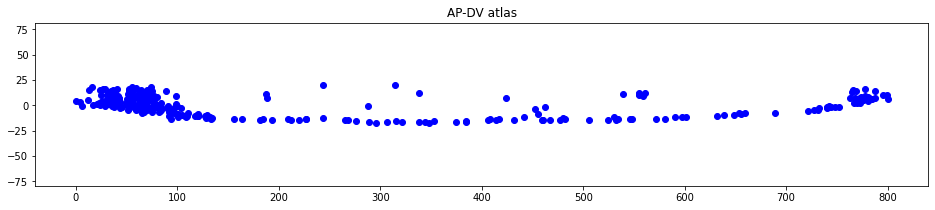

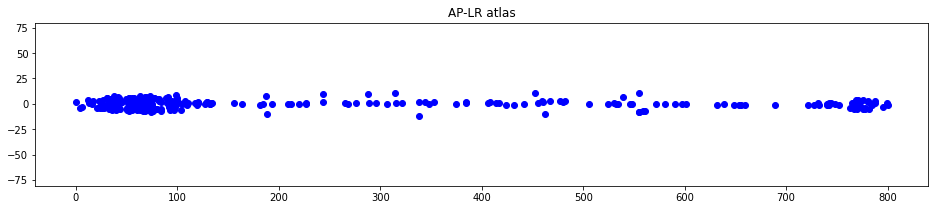

In [41]:
positions = load_positions('data/WholeWorm/atlas.csv')
generate_ap_dv_plot(positions, 'atlas')
generate_ap_lr_plot(positions, 'atlas')

Loaded in 237 positions from data/WholeWorm/Straightened Individuals/1_YAw.csv
Loaded in 248 positions from data/WholeWorm/Straightened Individuals/14_Aw.csv
Loaded in 237 positions from data/WholeWorm/Straightened Individuals/24_L4w.csv
Loaded in 218 positions from data/WholeWorm/Straightened Individuals/2_AMw.csv
Loaded in 264 positions from data/WholeWorm/Straightened Individuals/3_NPv16-64_YAw.csv
Loaded in 231 positions from data/WholeWorm/Straightened Individuals/7_YAw.csv
Loaded in 226 positions from data/WholeWorm/Straightened Individuals/9_YAw.csv


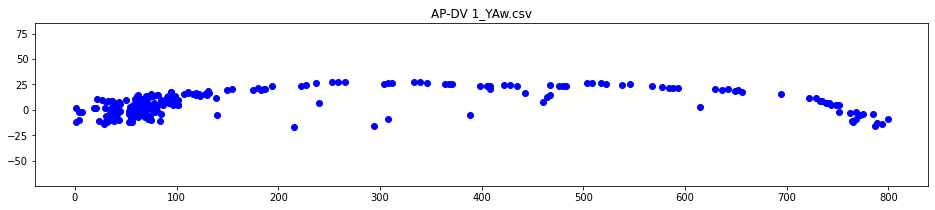

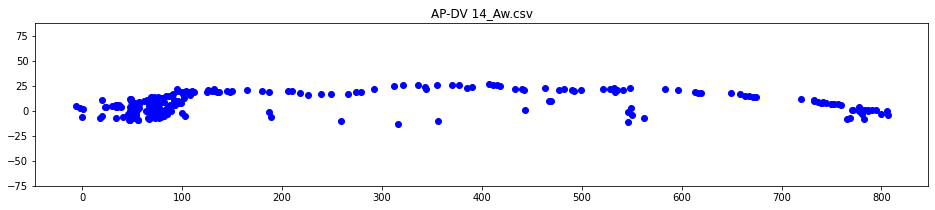

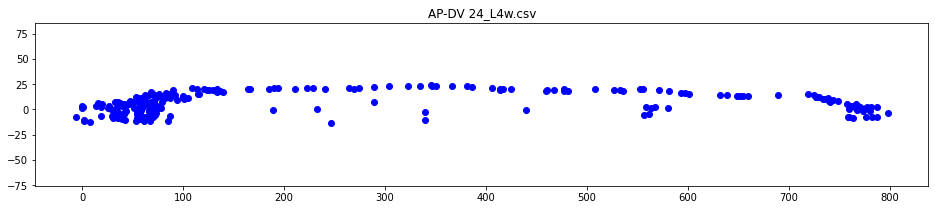

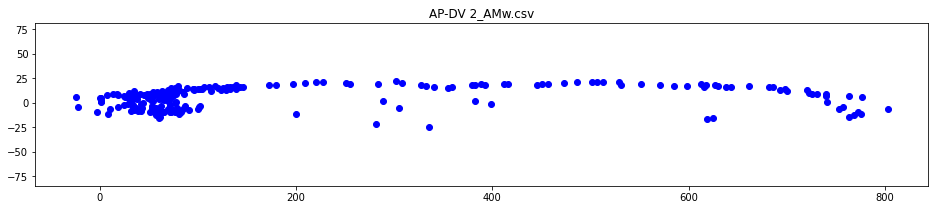

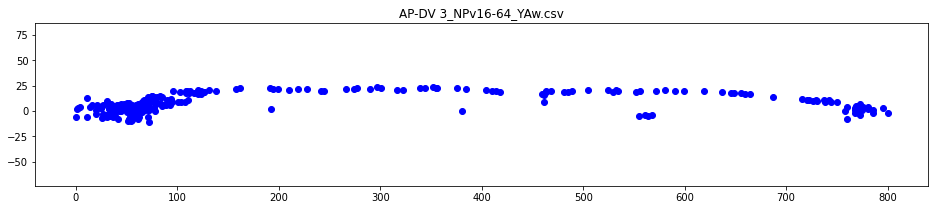

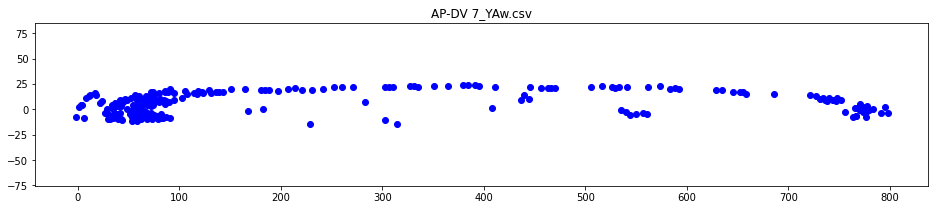

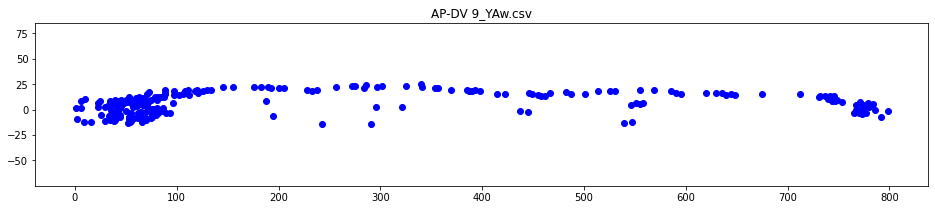

In [42]:
straightened = ['1_YAw.csv','14_Aw.csv','24_L4w.csv','2_AMw.csv','3_NPv16-64_YAw.csv','7_YAw.csv','9_YAw.csv']

for ref in straightened:
    filename = 'data/WholeWorm/Straightened Individuals/%s'%ref
    positions = load_positions(filename)
    generate_ap_dv_plot(positions, ref)
    

Loaded in 238 positions from data/WholeWorm/Raw Unstraightened Individuals with colors/1_YAw.csv
Loaded in 249 positions from data/WholeWorm/Raw Unstraightened Individuals with colors/14_Aw.csv
Loaded in 236 positions from data/WholeWorm/Raw Unstraightened Individuals with colors/24_L4w.csv
Loaded in 218 positions from data/WholeWorm/Raw Unstraightened Individuals with colors/2_AMw.csv
Loaded in 265 positions from data/WholeWorm/Raw Unstraightened Individuals with colors/3_NPv16-64_YAw.csv
Loaded in 231 positions from data/WholeWorm/Raw Unstraightened Individuals with colors/7_YAw.csv
Loaded in 227 positions from data/WholeWorm/Raw Unstraightened Individuals with colors/9_YAw.csv


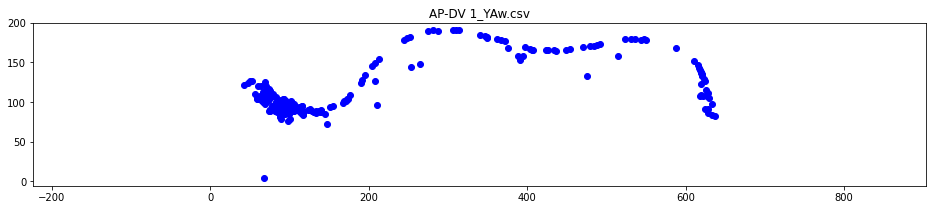

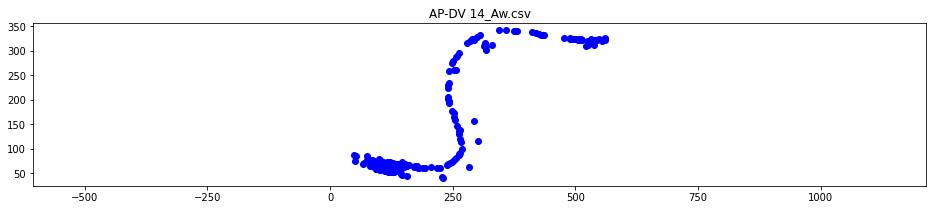

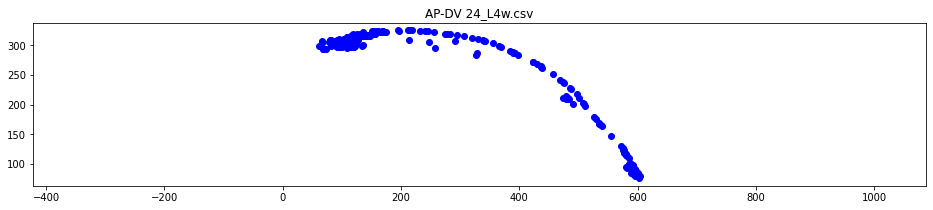

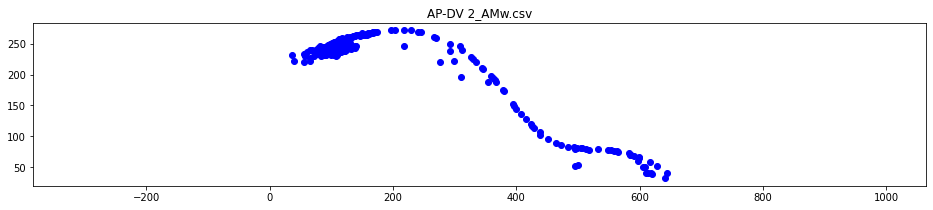

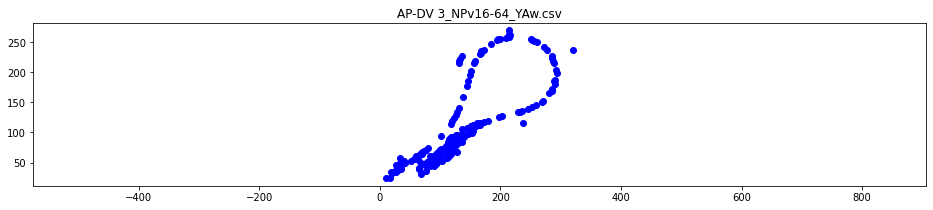

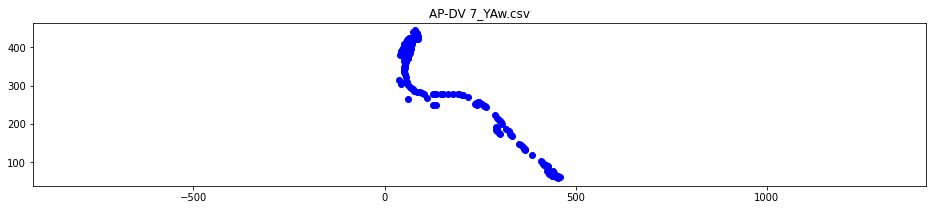

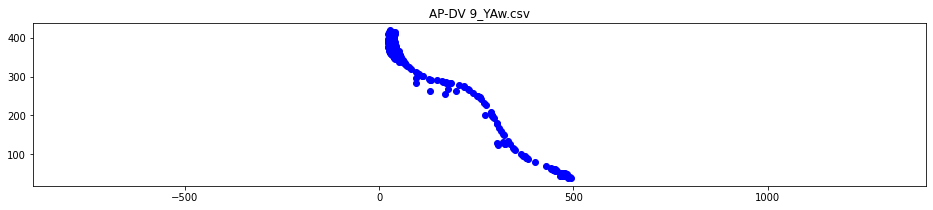

In [43]:
raw = ['1_YAw.csv','14_Aw.csv','24_L4w.csv','2_AMw.csv','3_NPv16-64_YAw.csv','7_YAw.csv','9_YAw.csv']

for ref in straightened:
    filename = 'data/WholeWorm/Raw Unstraightened Individuals with colors/%s'%ref
    positions = load_positions(filename)
    generate_ap_dv_plot(positions, ref)